# PUBG mobile data analysis

## In this notebook, I’ll be analyzing PUBG mobile game dataset, which is an online battle game, I will also build a model to predict the winning place percentage of a player. 
### In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) that get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In-game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves. My goal in this project is to build a storyline of the perfect winning PUBG match with the help of EDA and ML.

### importing libraries

In [51]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.neural_network import MLPRegressor
%matplotlib inline
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


### reading dataset

In [2]:
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')

In [3]:
train.shape

(4446966, 29)

### all the 29 columns wouldn't fit in the preview so I'll divide them

In [4]:
train.iloc[:,:15].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424


In [5]:
train.iloc[:,14:].head()

,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


### checking datatypes

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### looks like datatypes are fine

### checking missing values

In [7]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

### only one missing value, we'll drop it as it's not significant 

In [8]:
train.dropna(inplace=True)

### getting stats. info 

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
assists,4446965.0,0.233815,0.588573,0.0,0.0,0.0000,0.0000,22.0
boosts,4446965.0,1.106908,1.715794,0.0,0.0,0.0000,2.0000,33.0
damageDealt,4446965.0,130.717167,170.780629,0.0,0.0,84.2400,186.0000,6616.0
DBNOs,4446965.0,0.657876,1.145743,0.0,0.0,0.0000,1.0000,53.0
headshotKills,4446965.0,0.226820,0.602155,0.0,0.0,0.0000,0.0000,64.0
heals,4446965.0,1.370148,2.679982,0.0,0.0,0.0000,2.0000,80.0
killPlace,4446965.0,47.599361,27.462931,1.0,24.0,47.0000,71.0000,101.0
killPoints,4446965.0,505.006156,627.504921,0.0,0.0,0.0000,1172.0000,2170.0
kills,4446965.0,0.924784,1.558445,0.0,0.0,0.0000,1.0000,72.0
killStreaks,4446965.0,0.543955,0.710972,0.0,0.0,0.0000,1.0000,20.0


## EDA and visulaization

### The killers..

In [10]:
train['kills'].quantile(0.99)

7.0

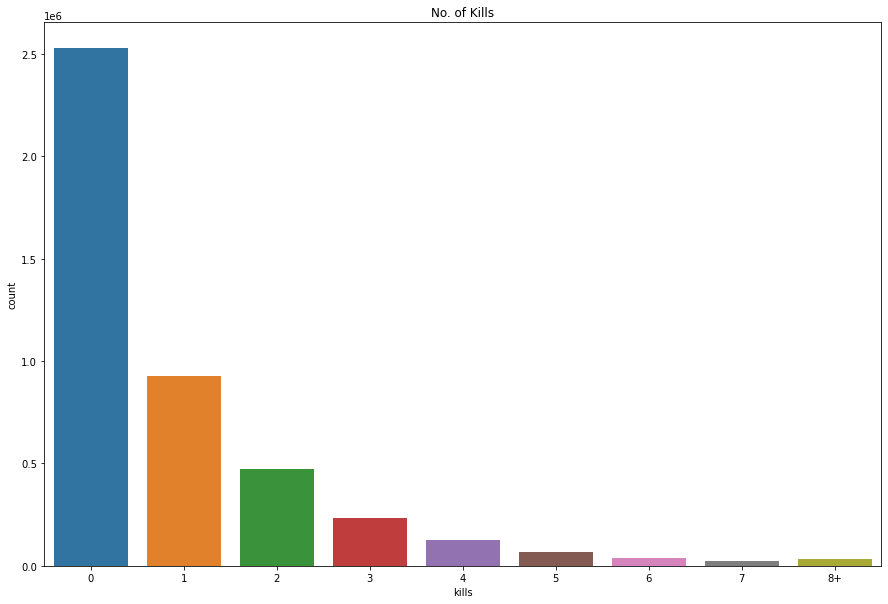

In [11]:
#replace any no of kills greater than 0.99 of data with 8 kills for better visuals
temp= train.copy()
temp.loc[temp['kills'] > temp['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(temp['kills'].astype('str').sort_values())
plt.title('No. of Kills');

### most people don't kill anyone, let's check if they deal damage..

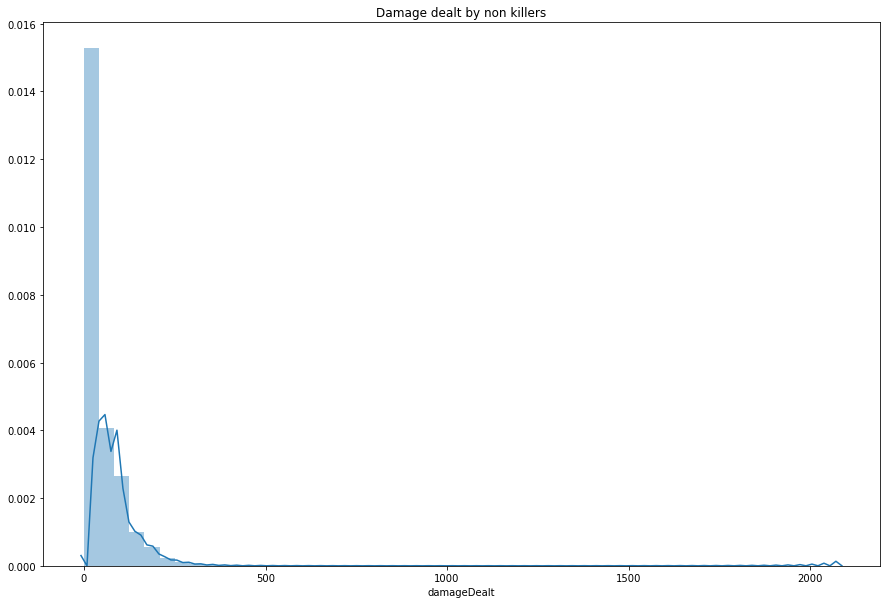

In [12]:
temp= train.copy()
temp =temp[temp['kills']==0]
plt.figure(figsize=(15,10))
sns.distplot(temp['damageDealt'])
plt.title('Damage dealt by non killers');

### it's obvious that most non killers don't deal damage too.

In [15]:
del temp

### Let's move on to check who wins most Solos,Duos or squads?

In [13]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

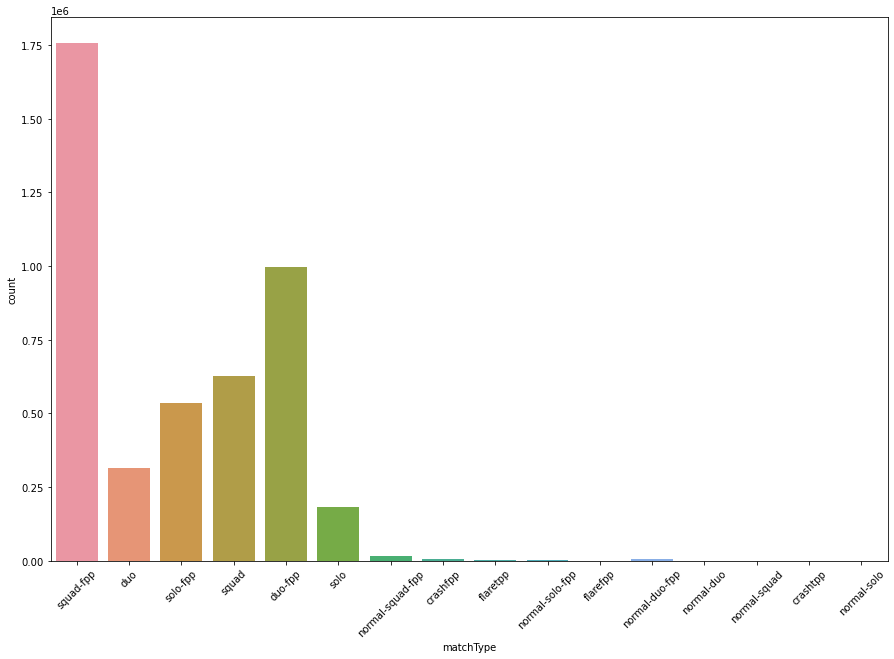

In [14]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.countplot(train['matchType'].astype('str'));

### most players play as squad "4members"

### let's check the matchType further as tpp and fpp are not that intersting it's just a mode

In [16]:
train['matchType'].value_counts()

squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: matchType, dtype: int64

### Combine all squad types into 1 column Squad, same for solo, duo other will be combined in others

In [17]:
train.matchType.replace(['squad-fpp','squad','normal-squad-fpp','normal-squad'],'Squad',inplace=True)

In [18]:
train.matchType.replace(['duo-fpp','duo','normal-duo-fpp','normal-duo'],'Duo',inplace=True)


In [19]:
train.matchType.replace(['solo-fpp','solo','normal-solo-fpp','normal-solo'],'Solo',inplace=True)

In [ ]:
train.matchType.replace(['crashfpp','flaretpp','flarefpp','crashtpp'],'Othertypes',inplace=True)

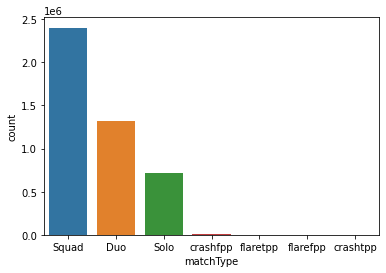

In [20]:
sns.countplot(train.matchType);

In [21]:
print('{}% of players play as Squads'.format(train.matchType.value_counts()['Squad']/len(train.matchType) *100 ))

53.97843248147895% of players play as Squads


## let's see what's the best strategy to win a match through: vehicles,kills damages and other variables.

### 1- Movement and vehicles

In [22]:
## The running players
print('A player travels an avg distance of {} meters'.format(train['walkDistance'].mean()))

A player travels an avg distance of 1154.218118648076 meters


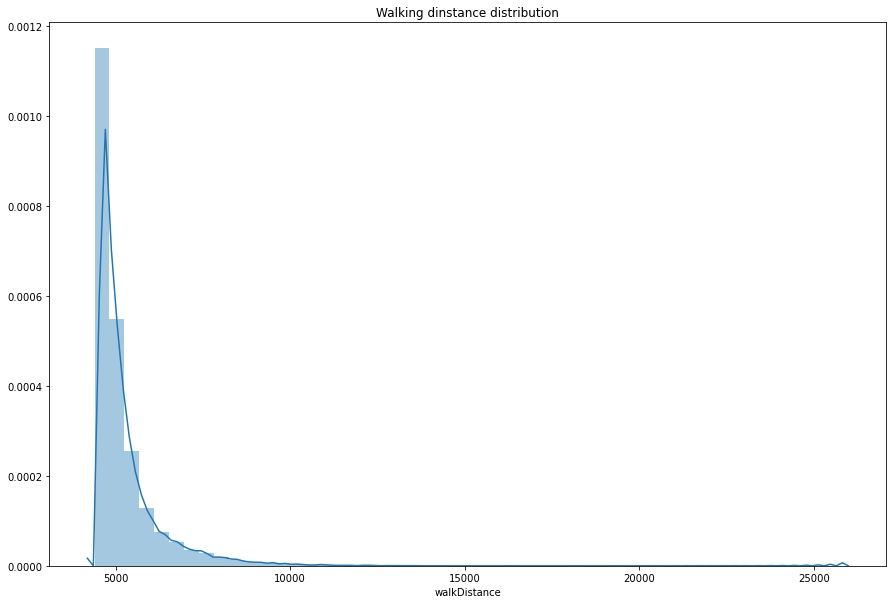

In [23]:
temp= train.copy()
temp=temp[temp['walkDistance'] > temp['walkDistance'].quantile(0.99)] 
plt.figure(figsize=(15,10))
sns.distplot(temp['walkDistance'])
plt.title('Walking dinstance distribution');

### The relationship between walking and winning

Text(0.5, 1.0, 'The relationship between winning and running')

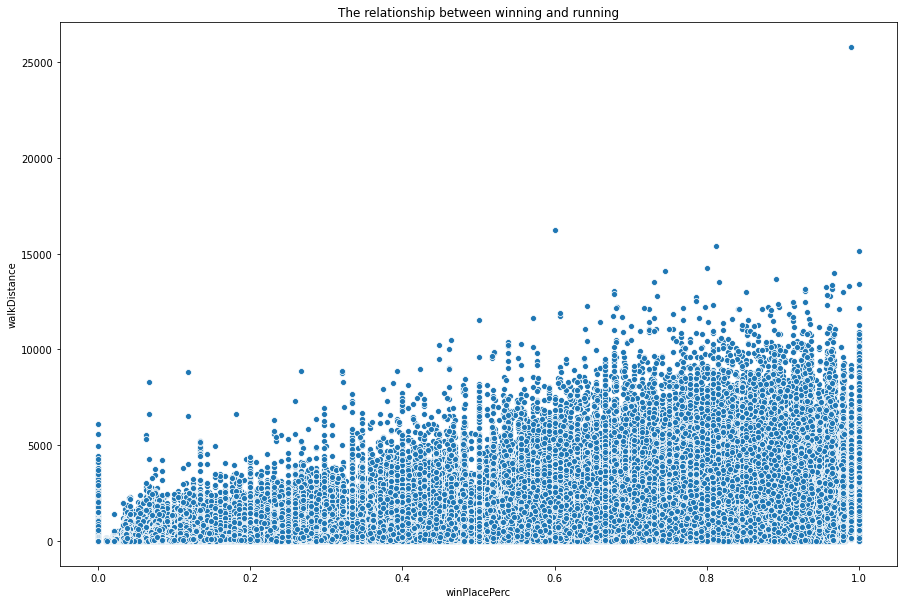

In [24]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='winPlacePerc',y='walkDistance',data=train)
plt.title('The relationship between winning and running')

### looks like there's a +ve correlation, let's get the exact value

In [25]:
train[['winPlacePerc','walkDistance']].corr()

,winPlacePerc,walkDistance
winPlacePerc,1.000000,0.810888
walkDistance,0.810888,1.000000


### Most walking players win according to the scatter plot with a correlation coefficient of 0.81

### let's check riding vehicles..

Text(0.5, 1.0, 'The relationship between winning and driving')

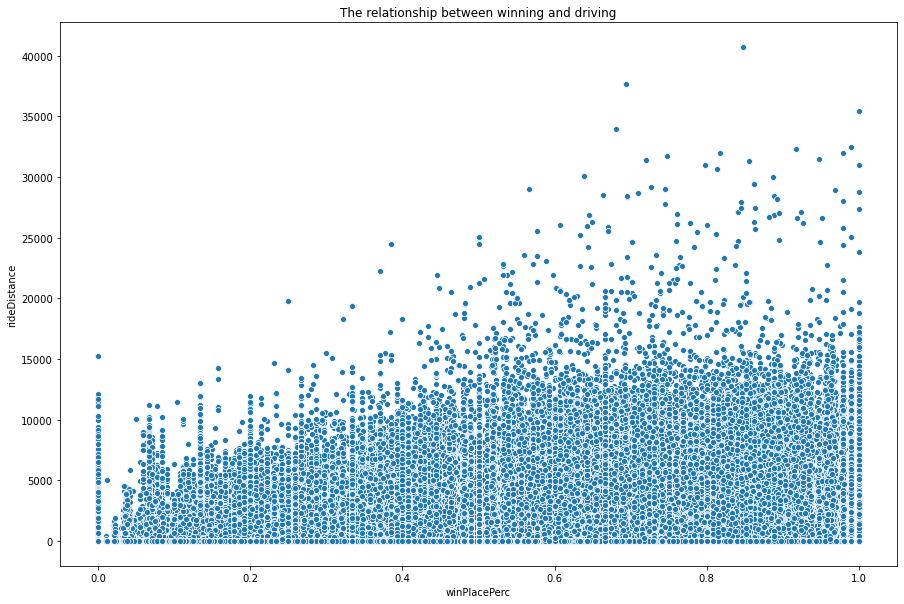

In [26]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='winPlacePerc',y='rideDistance',data=train)
plt.title('The relationship between winning and driving')

In [27]:
train[['winPlacePerc','rideDistance']].corr()

,winPlacePerc,rideDistance
winPlacePerc,1.000000,0.342915
rideDistance,0.342915,1.000000


### driving is less corelated, but there's a trick in PUBG a player can kill an enemy by destroyng the enemy's car by shooting it or throwing a bomb at it, let's check

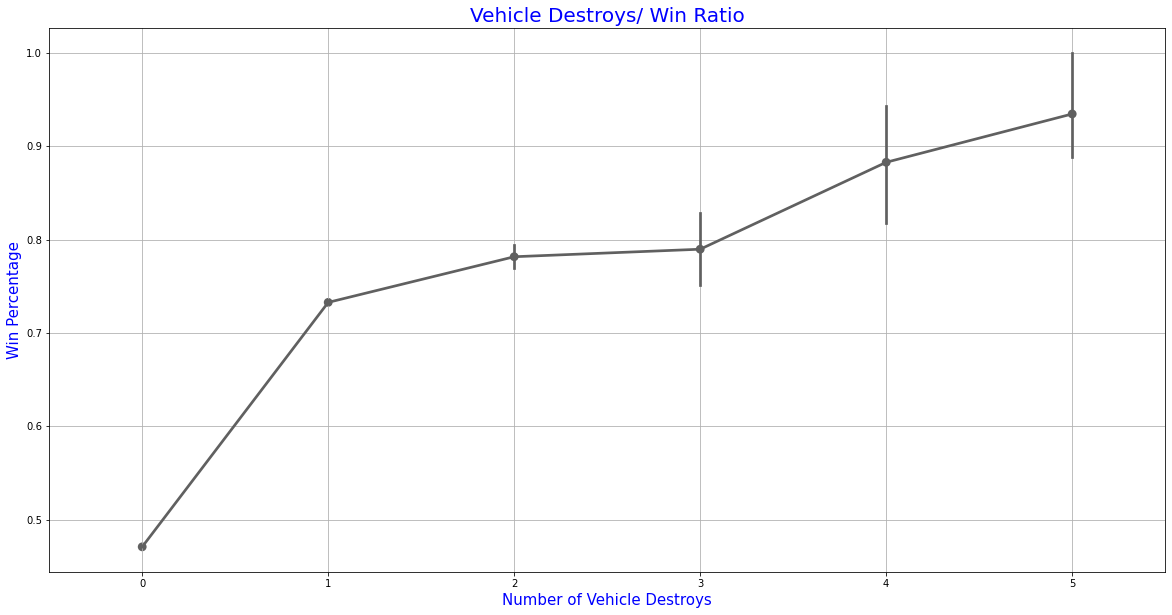

In [28]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=train,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid();

### The point plot, it shows that destroying at least on vehicle increases the chance of winning by ~35%, AWESOME!!

## PUBG is a team based game, when a member in your team is knocked down, you can revive him and bring him back in the game as long as he's not dead..let's check if that affects the winning.

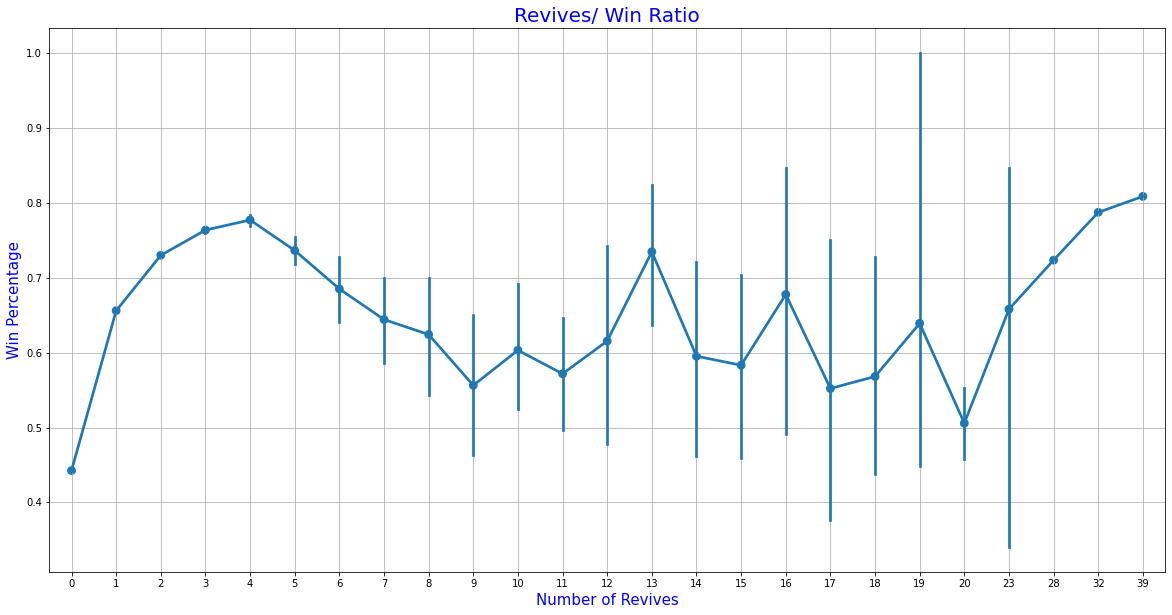

In [29]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='revives',y='winPlacePerc',data=train,alpha=0.8)
plt.xlabel('Number of Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Revives/ Win Ratio',fontsize = 20,color='blue')
plt.grid();

### looks like it doesn't affect winning that much.. 

# last thing I will check is the boosts and healing elements


Text(0.5, 1.0, 'The relationship between winning and healing elements')

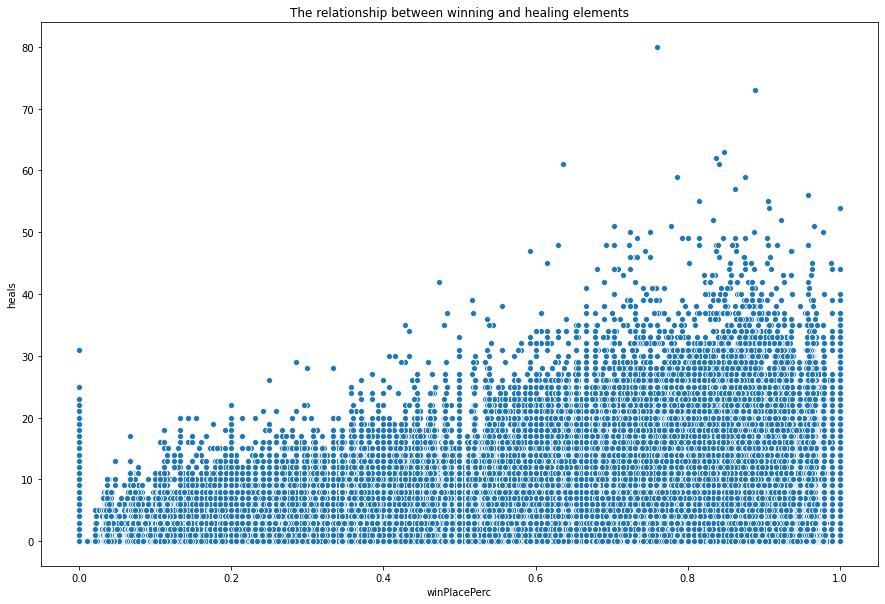

In [30]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='winPlacePerc',y='heals',data=train)
plt.title('The relationship between winning and healing elements')

In [31]:
train[['winPlacePerc','heals']].corr()

,winPlacePerc,heals
winPlacePerc,1.000000,0.427857
heals,0.427857,1.000000


In [32]:
train[['winPlacePerc','boosts']].corr()

,winPlacePerc,boosts
winPlacePerc,1.000000,0.634234
boosts,0.634234,1.000000


### looks like health boosters do relate to winning, as shown in the plots below with a correlation coefficient of 0.42 for heals, and 0.634 for boosts

## Feature engineering.

### let's check correlation between variables in our data

In [33]:
train.shape

(4446965, 29)

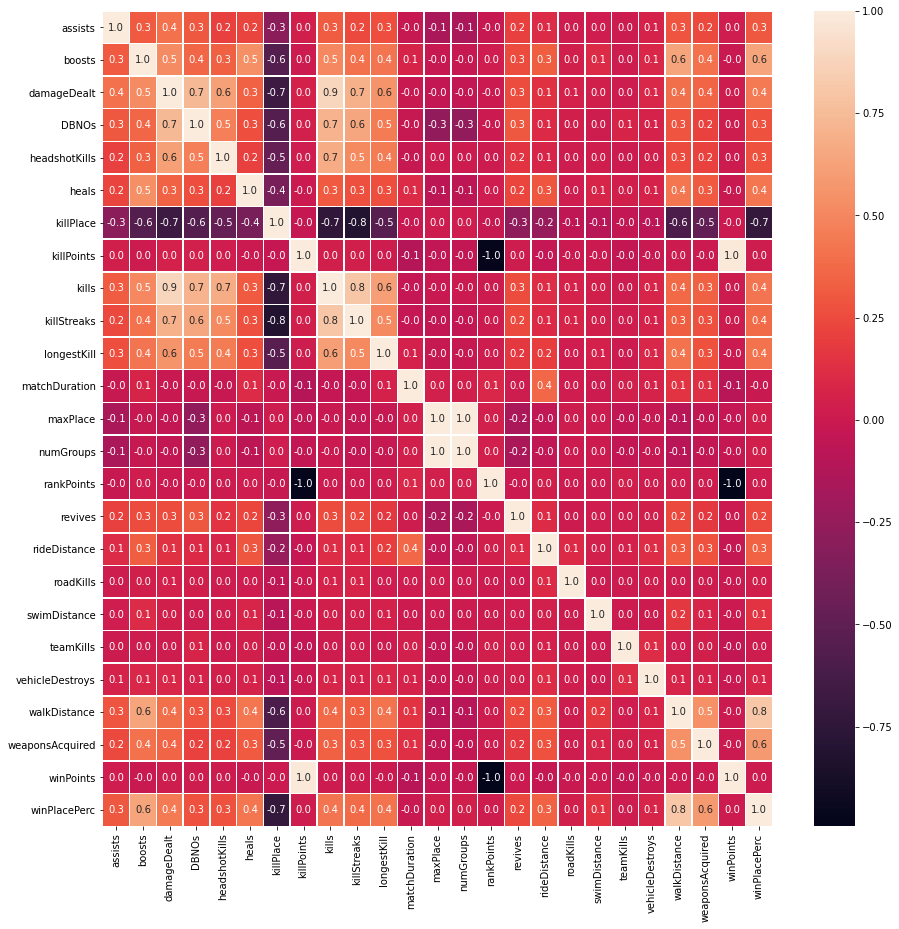

In [34]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);

### There are many attributes that have little corr values with the target variable..let's choose the top 5 attributes and explore them further,it's also to be noticed that the least correlated feature is the kill place

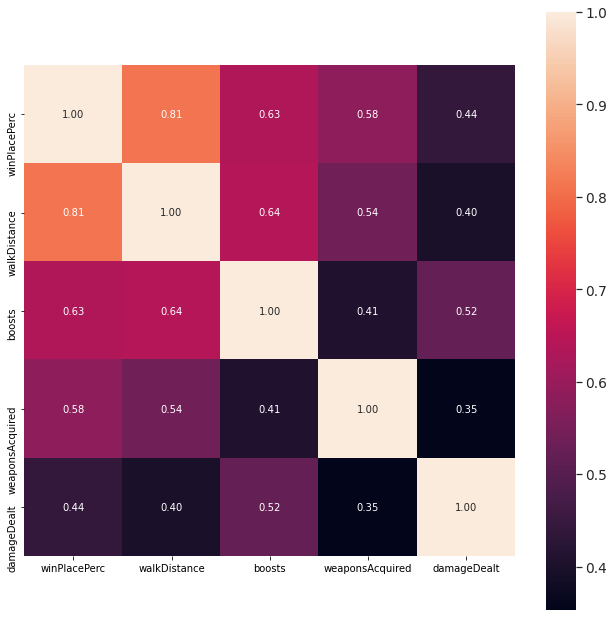

In [35]:
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(5, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### A PUBG game typically have 100 players but sometimes not all the 100 players join, let's create a feature indicates the number of players in a pubg match

### Creating new feature playersJoined that indicate the number of players in a game

In [36]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

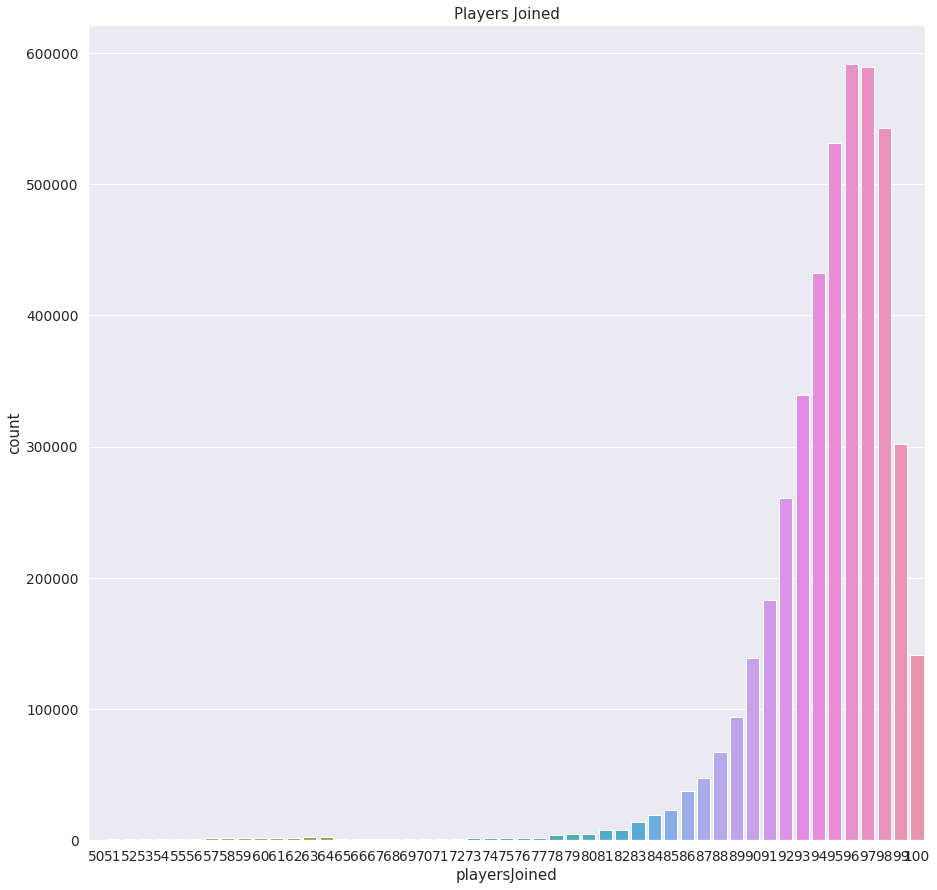

In [37]:
plt.figure(figsize=(15,15))
temp=train[train['playersJoined']>=50]
sns.countplot(temp['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

### In EDA we knew that bosts and healing elements increase tha chance of winning a game so let's put them in one feature also the walking,swimming and riding distance

In [38]:
train['healsAndBoosts'] = train['heals']+train['boosts']
train['totalDistance'] = train['walkDistance']+train['rideDistance']+train['swimDistance']

In [39]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'healsAndBoosts', 'totalDistance'],
      dtype='object')

### Get the number of players in a team corresponding to solos, duos, and squads in team columns

In [40]:
train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in train['numGroups']]

### selecting relavent data columns

In [41]:
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'healsAndBoosts', 'totalDistance', 'team'],
      dtype='object')

In [42]:
train=train[['assists','healsAndBoosts','damageDealt','DBNOs','kills','playersJoined','totalDistance','weaponsAcquired','winPlacePerc']]

In [43]:
train.head()

,assists,healsAndBoosts,damageDealt,DBNOs,kills,playersJoined,totalDistance,weaponsAcquired,winPlacePerc
0,0,0,0.00,0,0,96,244.8000,1,0.4444
1,0,0,91.47,0,0,91,1445.0445,5,0.6400
2,1,0,68.00,0,0,98,161.8000,2,0.7755
3,0,0,32.90,0,0,91,202.7000,3,0.1667
4,0,0,100.00,0,1,97,49.7500,2,0.1875


In [44]:
X=train.drop('winPlacePerc',axis=1)
y=train['winPlacePerc']

### getting rid of skewness

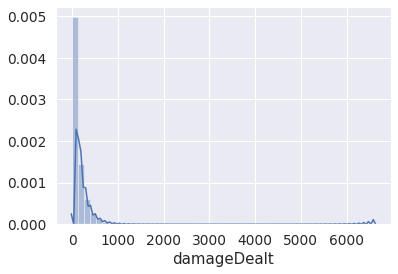

In [45]:
sns.distplot(X['damageDealt']);

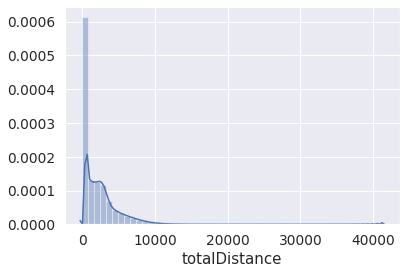

In [46]:
sns.distplot(X['totalDistance']);

### both are +ve skewed so i'll use cube root transformation to keep 0 values

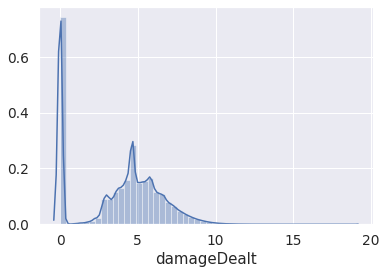

In [47]:
X['damageDealt']=X['damageDealt']**(1/3)
sns.distplot(X['damageDealt']);

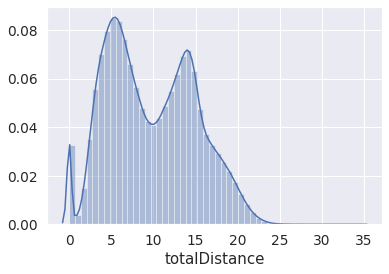

In [48]:
X['totalDistance']=X['totalDistance']**(1/3)
sns.distplot(X['totalDistance']);

## The winning strategy (My objective):
### So I’ve said in the beginning that I’m trying to find out the best strategy to win a PUBG game by using analytics, so here’s what I figured out from the analysis:
1. Play in a team.
2. Use healings and health-boosting elements.
3. Destroy your enemies vehicles.
4. Kill as many enemies as you can.
5. Move a lot and collect powerful weapons.


In [ ]:
## to do, regression :D